In [2]:
# pip install whyshift
# pip install folktables
import pandas as pd
import numpy as np
import cvxpy as cp
import random

In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from xgboost import XGBRegressor

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
STATES = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
          'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI',
          'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC',
          'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
          'VT', 'VA', 'WA', 'WV', 'WI', 'WY', 'PR']

In [6]:
state_list = STATES

In [7]:
# Selected features from whyshift
features=[
        'AGEP',     # age
        'COW',      # class of workers
        'SCHL',     # education attainments
        'MAR',      # marriage status
        'OCCP',     # occupation code
#       'RELP',     # relationship code
        'WKHP',     # usual hours worked per week
        'SEX',      # sex code
        'RAC1P',    # race code
      ]

# Load and Preprocess Data Sets

In [8]:
data = pd.read_csv('preprocessed_income_2018.csv')

In [9]:
data

Unnamed: 0  AGEP  COW  SCHL  MAR    OCCP  RELP  WKHP  SEX  RAC1P  \
0                 0  18.0  1.0  18.0  5.0  4720.0  17.0  21.0  2.0    2.0   
1                 1  53.0  5.0  17.0  5.0  3605.0  16.0  40.0  1.0    1.0   
2                 2  41.0  1.0  16.0  5.0  7330.0  17.0  40.0  1.0    1.0   
3                 3  18.0  6.0  18.0  5.0  2722.0  17.0   2.0  2.0    1.0   
4                 4  21.0  5.0  19.0  5.0  3870.0  17.0  50.0  1.0    1.0   
...             ...   ...  ...   ...  ...     ...   ...   ...  ...    ...   
1664495     1664495  39.0  6.0  16.0  5.0  6260.0   0.0  20.0  1.0    1.0   
1664496     1664496  38.0  6.0  14.0  5.0  4251.0   0.0  32.0  1.0    8.0   
1664497     1664497  37.0  1.0  19.0  3.0  7750.0  13.0  40.0  2.0    9.0   
1664498     1664498  47.0  1.0  16.0  1.0  8990.0   1.0  40.0  1.0    8.0   
1664499     1664499  34.0  1.0  16.0  5.0  6260.0   2.0  40.0  1.0    1.0   

         LogIncome        Y STATE  
0         7.377759   1600.0    AL  
1         9.210340  10000.0    AL  
2        10.085809  24000.0    AL  
3         5.192957    180.0    AL  
4        10.275051  29000.0    AL  
...            ...      ...   ...  
1664495   9.169518   9600.0    PR  
1664496   7.783224   2400.0    PR  
1664497   9.888374  19700.0    PR  
1664498   9.836279  18700.0    PR  
1664499   8.974618   7900.0    PR  

[1664500 rows x 13 columns]

In [10]:
X = data[features]
y = data['Y']
group = data['STATE'].to_numpy()

In [11]:
def binarize_data(data):

    ACSIncome_categories = {
        "COW": {
            1.0: "Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions",
            2.0: "Employee of a private not-for-profit, tax-exempt, or charitable organization",
            3.0: "Local government employee (city, county, etc.)",
            4.0: "State government employee",
            5.0: "Federal government employee",
            6.0: "Self-employed in own not incorporated business, professional practice, or farm",
            7.0: "Self-employed in own incorporated business, professional practice or farm",
            8.0: "Working without pay in family business or farm",
            9.0: "Unemployed and last worked 5 years ago or earlier or never worked",
        },
        "SCHL": {
            1.0: "No College degree", #"No schooling completed",
            2.0: "No College degree", #"Nursery school, preschool",
            3.0: "No College degree", #"Kindergarten",
            4.0: "No College degree", #"Grade 1",
            5.0: "No College degree", #"Grade 2",
            6.0: "No College degree", #"Grade 3",
            7.0: "No College degree", #"Grade 4",
            8.0: "No College degree", #"Grade 5",
            9.0: "No College degree", #"Grade 6",
            10.0: "No College degree", #"Grade 7",
            11.0: "No College degree", #"Grade 8",
            12.0: "No College degree", #"Grade 9",
            13.0: "No College degree", #"Grade 10",
            14.0: "No College degree", #"Grade 11",
            15.0: "No College degree", #"12th grade - no diploma",
            16.0: "No College degree", #"Regular high school diploma",
            17.0: "No College degree", #"GED or alternative credential",
            18.0: "No College degree", #"Some college, but less than 1 year",
            19.0: "No College degree", #"1 or more years of college credit, no degree",
            20.0: "No College degree", #"Associate's degree",
            21.0: "College degree", #"Bachelor's degree",
            22.0: "Higher", #"Master's degree",
            23.0: "Higher", #"Professional degree beyond a bachelor's degree",
            24.0: "Higher", #"Doctorate degree",
        },
        "MAR": {
            1.0: "Married",
            2.0: "Not Married", #"Widowed",
            3.0: "Not Married", #"Divorced",
            4.0: "Not Married", #"Separated",
            5.0: "Not Married", #"Never married or under 15 years old",
        },
        "SEX": {1.0: "Male", 2.0: "Female"},
        "RAC1P": {
            1.0: "White", #"White alone",
            2.0: "Black or African American", #"Black or African American alone",
            3.0: "Some Other Race", # "American Indian alone",
            4.0: "Some Other Race", #"Alaska Native alone",
            5.0: "Some Other Race", #"American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other",
            6.0: "Asian", #"Asian alone",
            7.0: "Some Other Race", #"Native Hawaiian and Other Pacific Islander alone",
            8.0: "Some Other Race", #"Some Other Race alone",
            9.0: "Some Other Race", #"Two or More Races",
        },
    }

    for col, mapping in ACSIncome_categories.items():
        data[col] = data[col].map(mapping)
    data = pd.get_dummies(data, columns=ACSIncome_categories.keys())
    data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)
    
    return data

In [12]:
X

AGEP  COW  SCHL  MAR    OCCP  WKHP  SEX  RAC1P
0        18.0  1.0  18.0  5.0  4720.0  21.0  2.0    2.0
1        53.0  5.0  17.0  5.0  3605.0  40.0  1.0    1.0
2        41.0  1.0  16.0  5.0  7330.0  40.0  1.0    1.0
3        18.0  6.0  18.0  5.0  2722.0   2.0  2.0    1.0
4        21.0  5.0  19.0  5.0  3870.0  50.0  1.0    1.0
...       ...  ...   ...  ...     ...   ...  ...    ...
1664495  39.0  6.0  16.0  5.0  6260.0  20.0  1.0    1.0
1664496  38.0  6.0  14.0  5.0  4251.0  32.0  1.0    8.0
1664497  37.0  1.0  19.0  3.0  7750.0  40.0  2.0    9.0
1664498  47.0  1.0  16.0  1.0  8990.0  40.0  1.0    8.0
1664499  34.0  1.0  16.0  5.0  6260.0  40.0  1.0    1.0

[1664500 rows x 8 columns]

In [13]:
X = binarize_data(X) 

/var/folders/cx/4m3bjvy92pd12vtkpqfc0jcm0000gn/T/ipykernel_1668/1264710390.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].map(mapping)
/var/folders/cx/4m3bjvy92pd12vtkpqfc0jcm0000gn/T/ipykernel_1668/1264710390.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data = data.applymap(lambda x: int(x) if isinstance(x, bool) else x)


In [14]:
X

AGEP    OCCP  WKHP  \
0        18.0  4720.0  21.0   
1        53.0  3605.0  40.0   
2        41.0  7330.0  40.0   
3        18.0  2722.0   2.0   
4        21.0  3870.0  50.0   
...       ...     ...   ...   
1664495  39.0  6260.0  20.0   
1664496  38.0  4251.0  32.0   
1664497  37.0  7750.0  40.0   
1664498  47.0  8990.0  40.0   
1664499  34.0  6260.0  40.0   

         COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions  \
0                                                        1                                                                  
1                                                        0                                                                  
2                                                        1                                                                  
3                                                        0                                                                  
4                                                        0                                                                  
...                                                    ...                                                                  
1664495                                                  0                                                                  
1664496                                                  0                                                                  
1664497                                                  1                                                                  
1664498                                                  1                                                                  
1664499                                                  1                                                                  

         COW_Employee of a private not-for-profit, tax-exempt, or charitable organization  \
0                                                        0                                  
1                                                        0                                  
2                                                        0                                  
3                                                        0                                  
4                                                        0                                  
...                                                    ...                                  
1664495                                                  0                                  
1664496                                                  0                                  
1664497                                                  0                                  
1664498                                                  0                                  
1664499                                                  0                                  

         COW_Federal government employee  \
0                                      0   
1                                      1   
2                                      0   
3                                      0   
4                                      1   
...                                  ...   
1664495                                0   
1664496                                0   
1664497                                0   
1664498                                0   
1664499                                0   

         COW_Local government employee (city, county, etc.)  \
0                                                        0    
1                                                        0    
2                                                        0    
3                                                        0    
4                                                        0    
...                                                    ...    
1664495                                         

In [15]:
group

array(['AL', 'AL', 'AL', ..., 'PR', 'PR', 'PR'], dtype=object)

# Data Fusion under Distributional Uncertainty

### Calculate Weights: Our Method

In [16]:
def gen_summary(data, group, states):
    summary_data = pd.DataFrame()
    for i in range(len(states)):
        if np.sum(group == states[i]) > 0:
            total = data[group == states[i]][["OCCP"]].size
            new_summary = data[group == states[i]].groupby(["OCCP"]).size()/ total
            new_summary = new_summary.to_frame(states[i])
            summary_data = pd.concat([summary_data, new_summary], axis = 1)
    summary_data = summary_data.fillna(0)
    summary_data = summary_data.sort_index()
    return summary_data

In [17]:
gen_summary(X, group, ["WA", "CA", "PR"])

WA        CA        PR
OCCP                                
10.0    0.008312  0.010308  0.004630
20.0    0.006584  0.006394  0.002315
40.0    0.000275  0.000358  0.000110
51.0    0.003805  0.004830  0.001102
52.0    0.002453  0.002888  0.001874
...          ...       ...       ...
9760.0  0.000501  0.000296  0.000661
9800.0  0.000726  0.000174  0.000110
9810.0  0.001152  0.000394  0.000110
9825.0  0.001878  0.001768  0.000110
9830.0  0.003029  0.001651  0.000441

[529 rows x 3 columns]

In [18]:
def get_dist_weights (X, y, tol = 1e-5):
    X = X.to_numpy()
    y = y.to_numpy()[:,0]
    beta = cp.Variable(X.shape[1])
    obj = cp.Minimize(cp.sum_squares(y - X @ beta))
    prob = cp.Problem(obj, [cp.sum(beta) == 1, beta>=0])
    prob.solve()
    beta = beta.value
    beta[beta < tol] = 0
    return beta

### Calculate Weights: Importance Weighting

In [19]:
def get_imp_weights (X, group, target):
    cf_model = XGBClassifier(max_depth=3,random_state=0)
    le = LabelEncoder()
    label = le.fit_transform(group == target)
    cf_model.fit(X, label)
    #label_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    probs = cf_model.predict_proba(X[group != target])
    weights = probs[:, 1]/probs[:, 0] * np.sum(group!=target) / np.sum(group==target)
    return weights

### Adding New Data Source (PR)

In [20]:
def simulate(target, train, perturb, n_t, n_p, n_0=20000, random_seed=0):
        
        # sample data sets
        random.seed(random_seed)
        target_indices = list(np.where(group == target)[0])
        random_target_indices = random.sample(list(np.where(group == target)[0]), min(n_0, len(target_indices)))
        random_indices = random.sample(list(np.where(group == train)[0]), n_t)
        random_indices += random.sample(list(np.where(group == perturb)[0]), n_p)
        n_seq = np.linspace(1000, (n_t + n_p), num = int((n_t + n_p)/1000))
        ours = np.array([0.0 for _ in range(len(n_seq))])       # mse for our method
        pooled = np.array([0.0 for _ in range(len(n_seq))])     # mse for pooling
        propsc = np.array([0.0 for _ in range(len(n_seq))])     # mse for propensity score method (impotance weighting)

        for i in range(len(n_seq)):
                newX = X.iloc[random_target_indices + random_indices[:int(n_seq[i])]]
                newY = y.iloc[random_target_indices + random_indices[:int(n_seq[i])]]
                newG = group[random_target_indices + random_indices[:int(n_seq[i])]]
                
                # Create Covariate Matrix and Fit Weights
                summary = gen_summary(newX, newG, [target] + [train] + [perturb])
                dist_weights = get_dist_weights(summary.loc[:, summary.columns != target], 
                                                summary.loc[:, summary.columns == target])
                samp_weights = get_imp_weights(newX, newG, target)
                
                w = []
                w += [dist_weights[0] * np.sum(newG!=target) / np.sum(newG==train)] * n_t
                if len(dist_weights) > 1:
                        w += [dist_weights[1] * np.sum(newG!=target) / np.sum(newG==perturb)] * n_p
                w = w[:int(n_seq[i])]
                
                # Define XGBoost 
                newY = np.log(newY)
                model_ours = XGBRegressor(max_depth=3, random_state = 0)
                model_pooled = XGBRegressor(max_depth=3, random_state = 0)
                model_propsc = XGBRegressor(max_depth=3, random_state = 0)
                # Fit XGBoost
                model_pooled.fit(newX[newG != target], newY[newG != target])
                model_ours.fit(newX[newG != target], newY[newG != target], sample_weight = w)
                model_propsc.fit(newX[newG != target], newY[newG != target], sample_weight = samp_weights)
                # Evaluate fitted XGBoost
                ours[i] = np.sqrt(np.mean((model_ours.predict(newX[newG == target]) - newY[newG == target]) ** 2))
                pooled[i] = np.sqrt(np.mean((model_pooled.predict(newX[newG == target]) - newY[newG == target]) ** 2))
                propsc[i] = np.sqrt(np.mean((model_propsc.predict(newX[newG == target]) - newY[newG == target]) ** 2))
                        
        return (ours, pooled, propsc)

In [21]:
def create_plot (ours, pooled, propsc, target, n_t, n_p):

    # Flatten the arrays to create long-form collections
    ours_flat = ours.flatten()
    pooled_flat = pooled.flatten()
    propsc_flat = propsc.flatten()
    
    # Create an array indicating the type (regs or ours)
    type_array = np.repeat(['Equal Weights', 'Our Weights', 'Importance Weights'], ours.shape[0] * ours.shape[1])

    # Create an array of alpha values for each element
    n_seq = np.linspace(1000, (n_t + n_p), num = int((n_t + n_p)/1000))
    alpha_array = np.tile(n_seq, ours.shape[0] * 3)
    
    # Create a DataFrame for seaborn
    data = {
        'Alpha': alpha_array,
        'Value': np.concatenate([pooled_flat, ours_flat, propsc_flat]),
        'Type': type_array
    }
    df = pd.DataFrame(data)

    sns.reset_defaults()
    g = sns.lineplot(x='Alpha', y='Value', hue='Type', style='Type', markers=["o"]*3,
                     data=df, errorbar='sd')  # 'sd' for error bars based on standard deviation
    sns.move_legend(g, "upper center")
    g.axvline(x=n_t, color = 'grey', linestyle='--')
    y_at_x_5000 = np.mean(df[df['Alpha'] == n_t]['Value'])
    g.hlines(y=y_at_x_5000, color = 'grey', xmin=n_t, xmax=(n_t + n_p), linestyle='--')
    g.annotate('"PR" data added', xy=(n_t, y_at_x_5000), xytext=(n_t + 3000, y_at_x_5000 + 0.02),
               arrowprops=dict(facecolor='black', arrowstyle='->', lw=0.7),
               fontsize=13, ha='center')
    g.legend(loc='upper center', bbox_to_anchor=(0.45, -0.15), ncol=2, fontsize = 14)
    g.set_title('Target State: '+target, y = 1.02, fontsize = 14)
    g.set(xlabel='Training data size', ylabel='MSE')
    g.set_xlabel('Training data size', fontsize=14)  
    g.set_ylabel('MSE', fontsize=14)

    plt.show()
    
    return df, g

In [22]:
def add_source_sim (target, n_t = 5000, n_p = 9000, nsims = 1000):
    ours = np.array([[0.0] * int((n_t + n_p)/1000) for _ in range(nsims)])
    pooled = np.array([[0.0] * int((n_t + n_p)/1000) for _ in range(nsims)])
    propsc = np.array([[0.0] * int((n_t + n_p)/1000) for _ in range(nsims)])
    for i_sim in range(nsims):
        ours[i_sim], pooled[i_sim], propsc[i_sim] = simulate(target, "CA", "PR", random_seed=i_sim, n_t = n_t, n_p = n_p)
    return ours, pooled, propsc

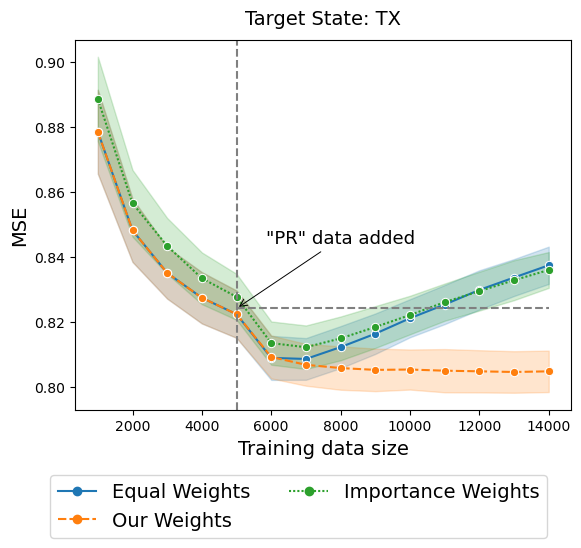

In [23]:
state = "TX"
ours, pooled, propsc = add_source_sim(state, nsims = 100)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df, g = create_plot(ours, pooled, propsc, target = state, n_t = 5000, n_p = 9000)

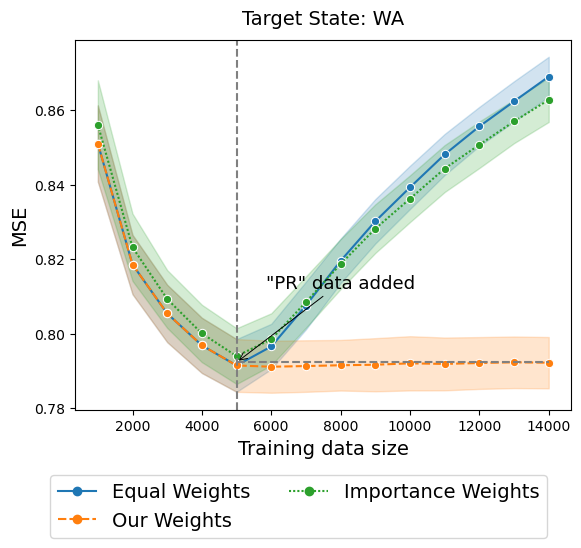

In [24]:
state = "WA"
ours, pooled, propsc = add_source_sim(state, nsims = 100)
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df, g = create_plot(ours, pooled, propsc, target = state, n_t = 5000, n_p = 9000)

AL


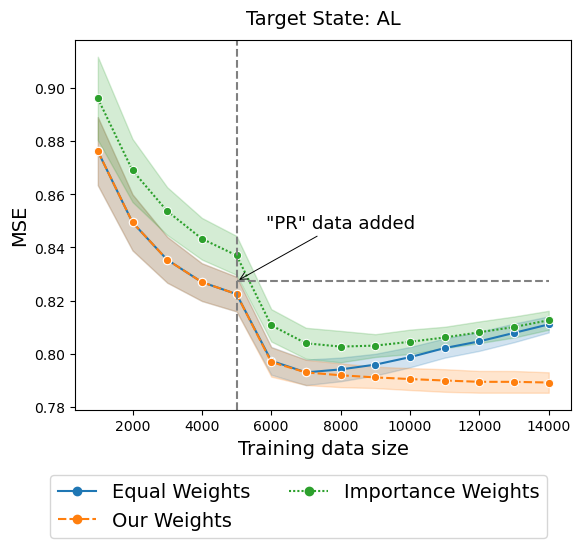

AK


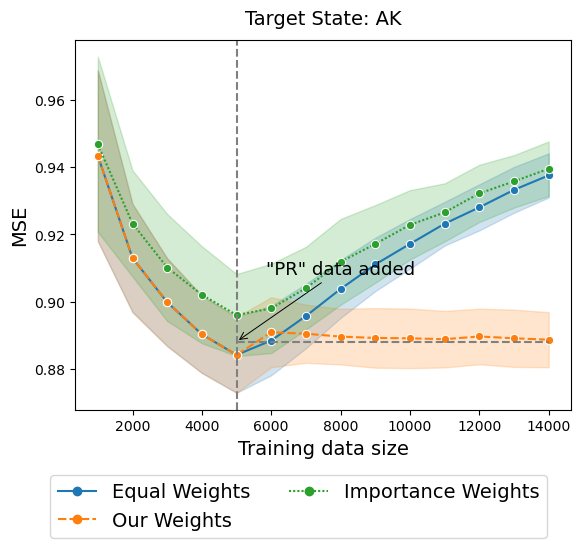

AZ


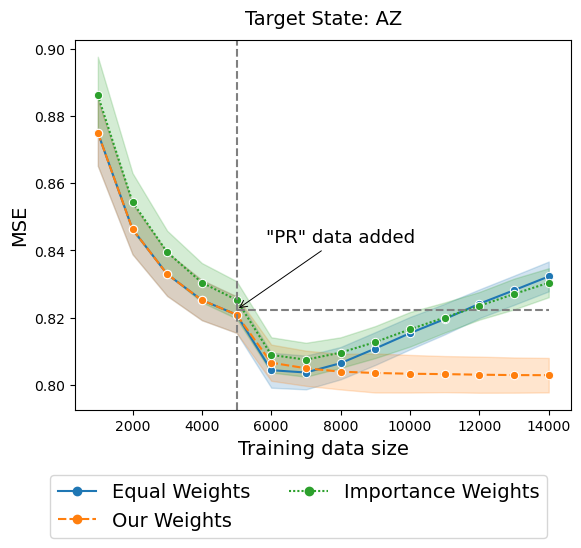

AR


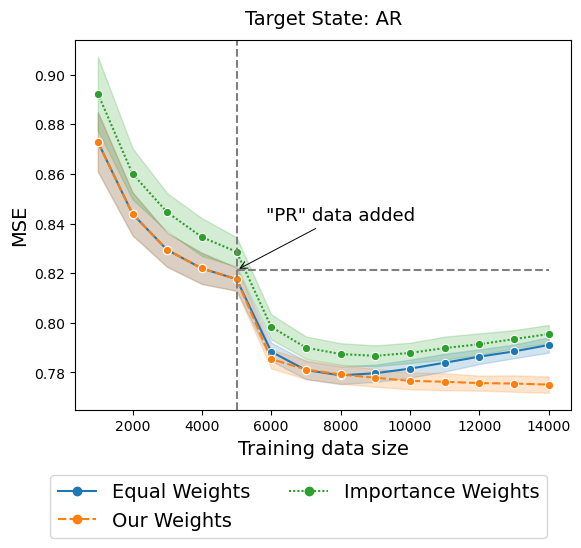

CO


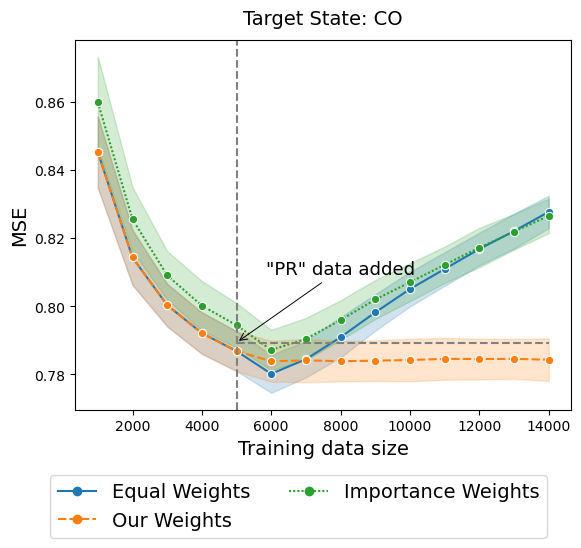

CT


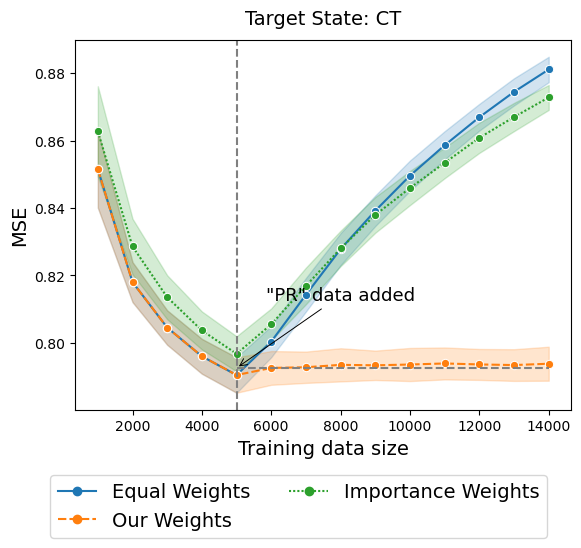

DE


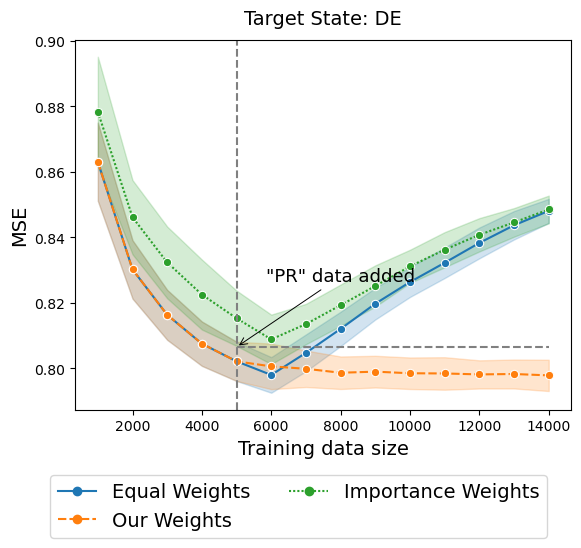

FL


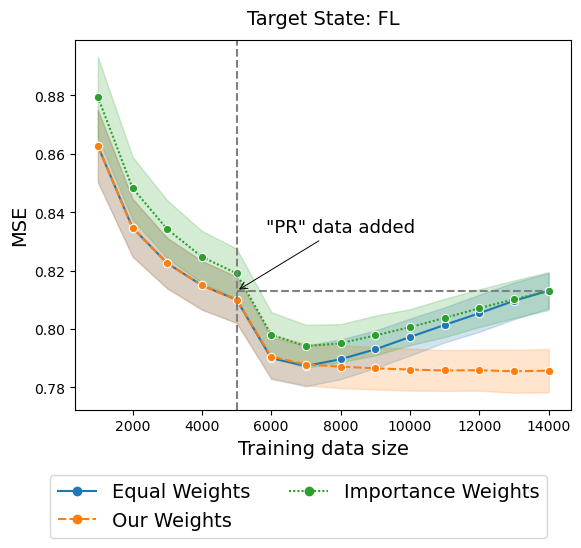

GA


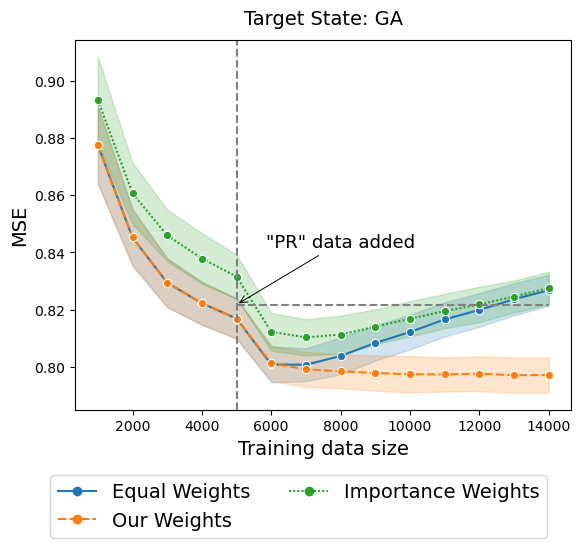

HI


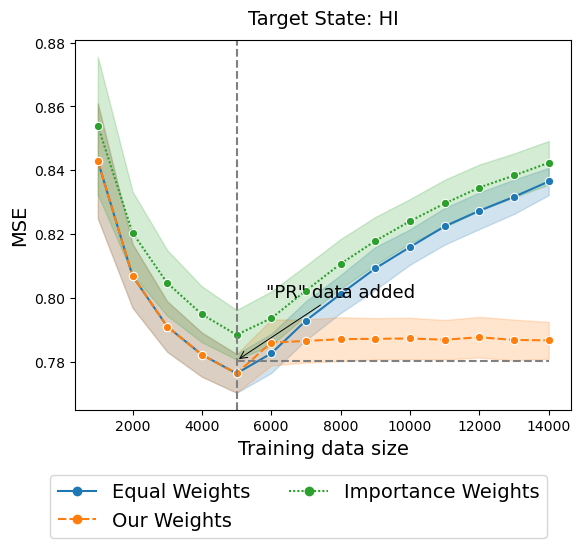

ID


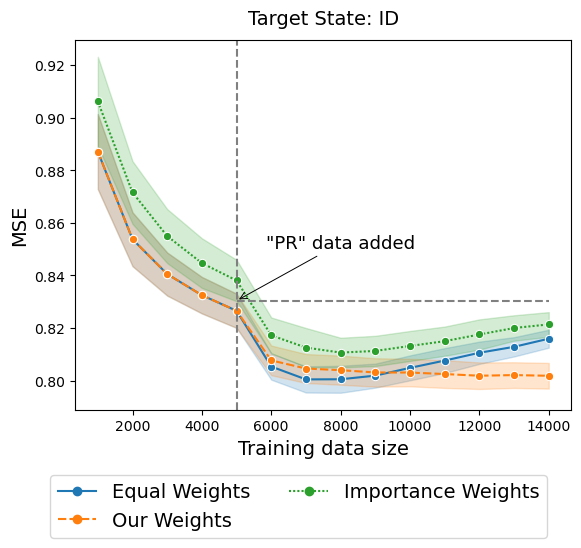

IL


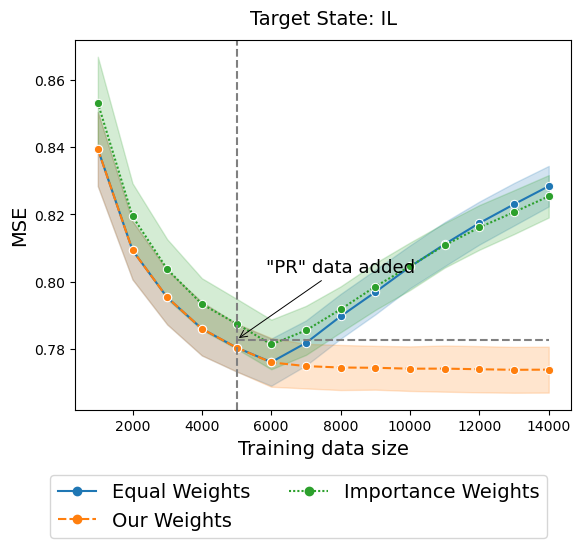

IN


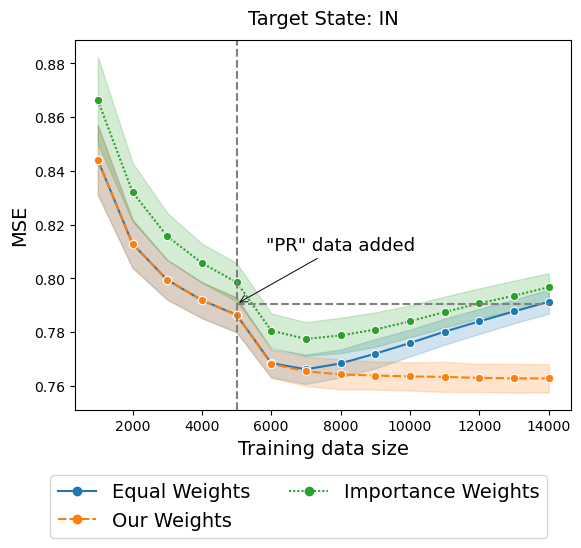

IA


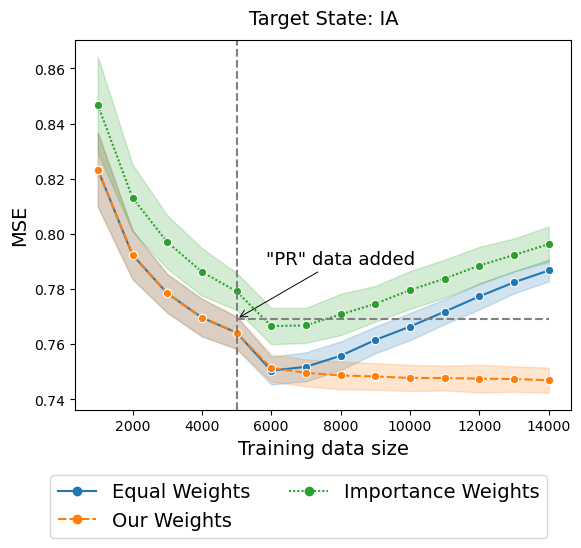

KS


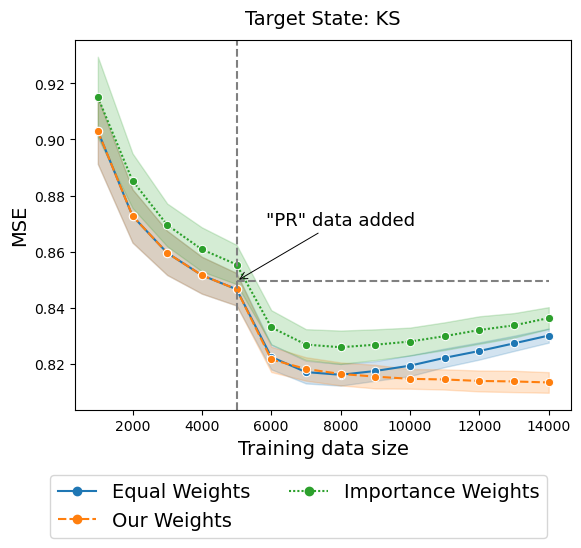

KY


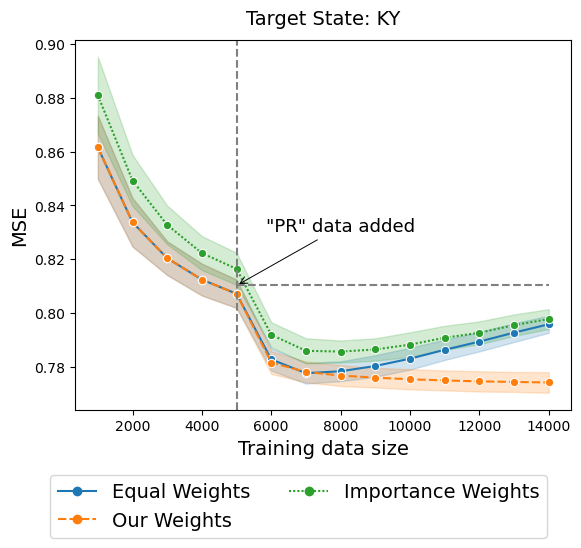

LA


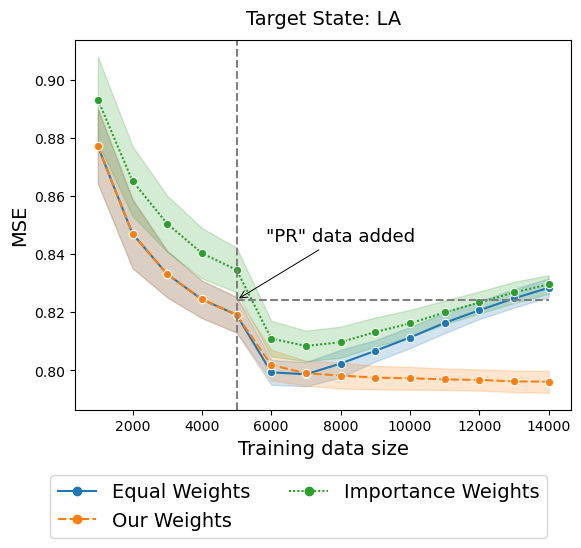

ME


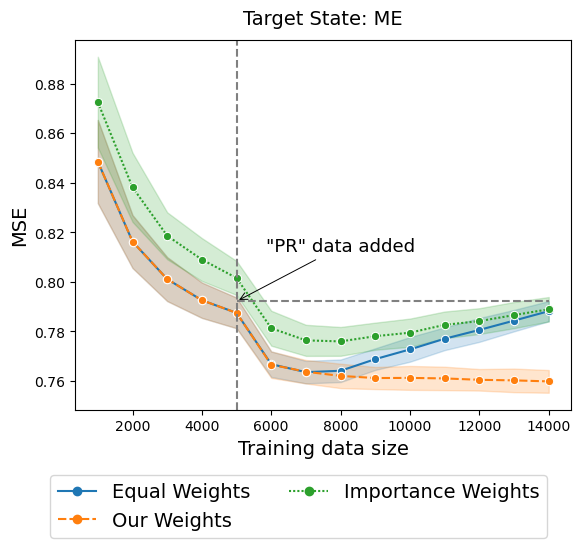

MD


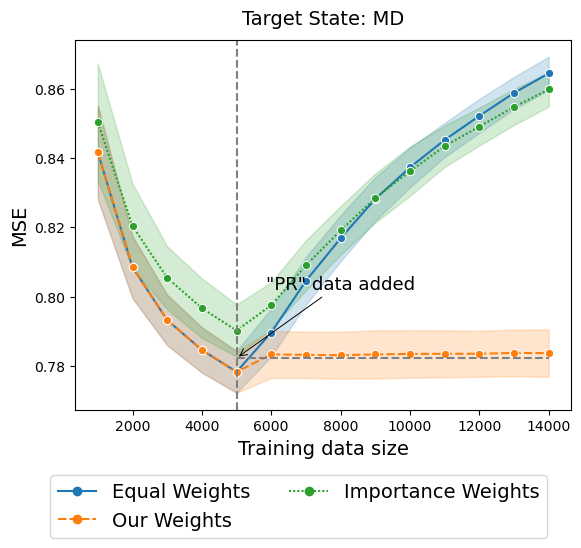

MA


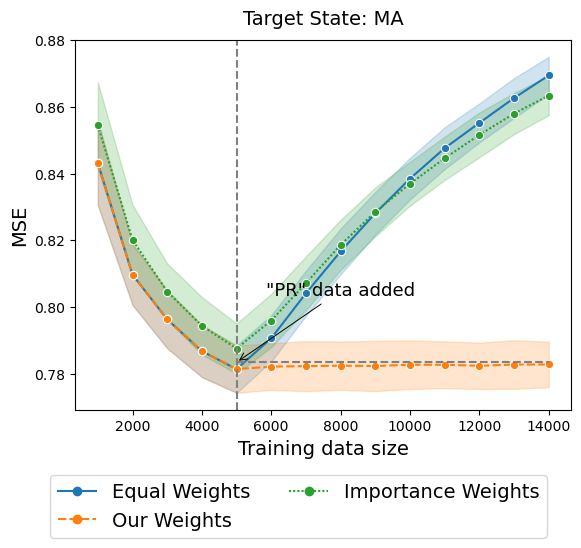

MI


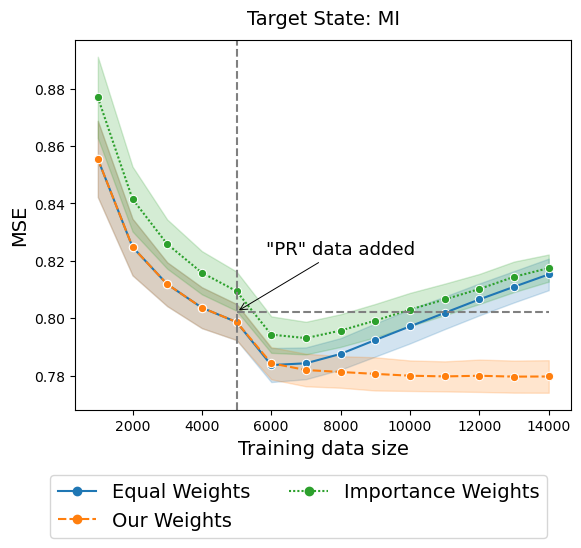

MN


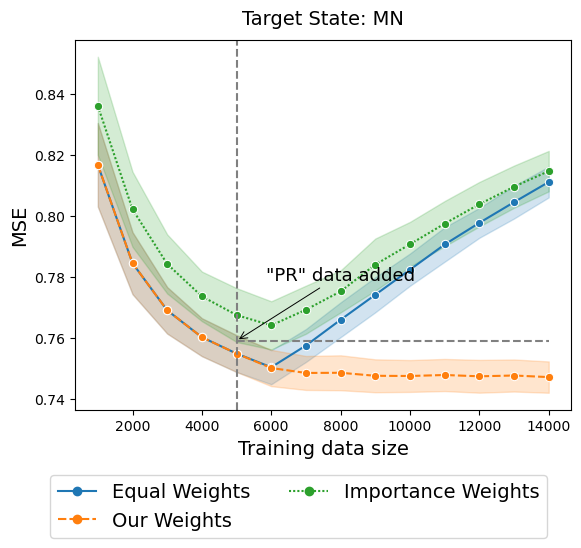

MS


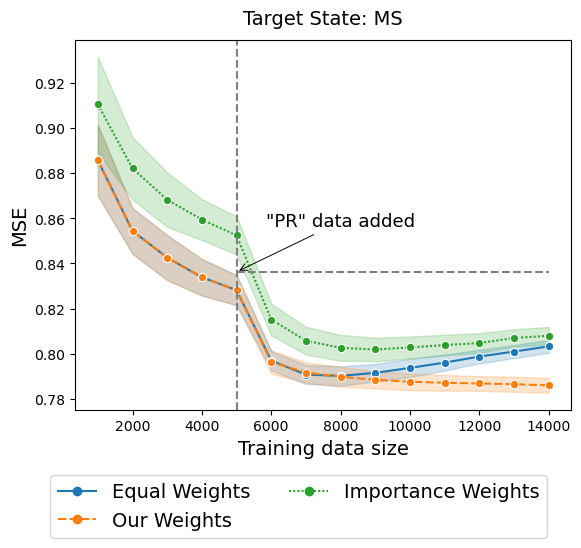

MO


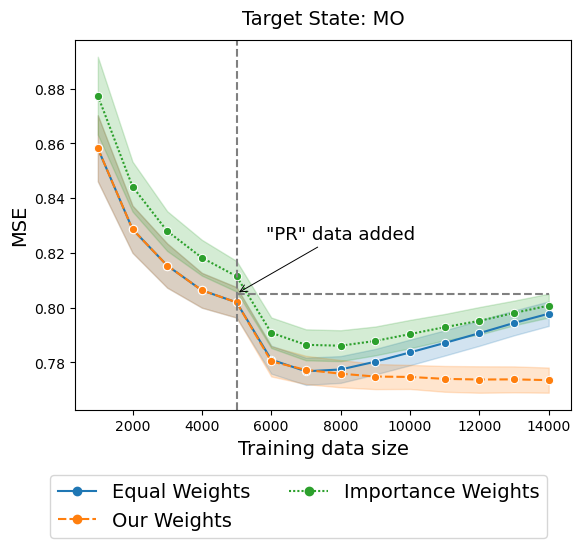

MT


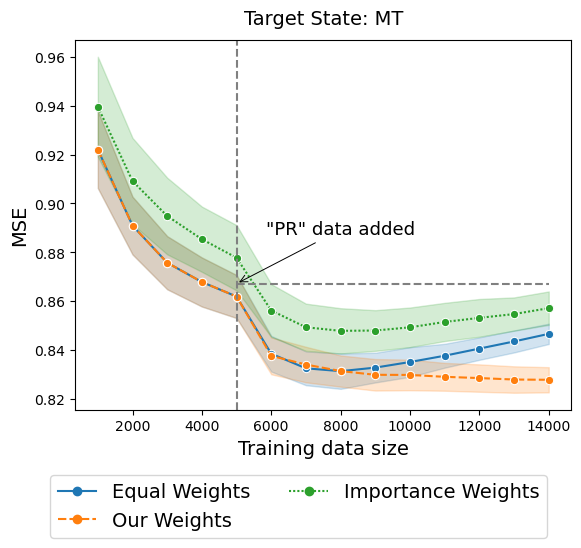

NE


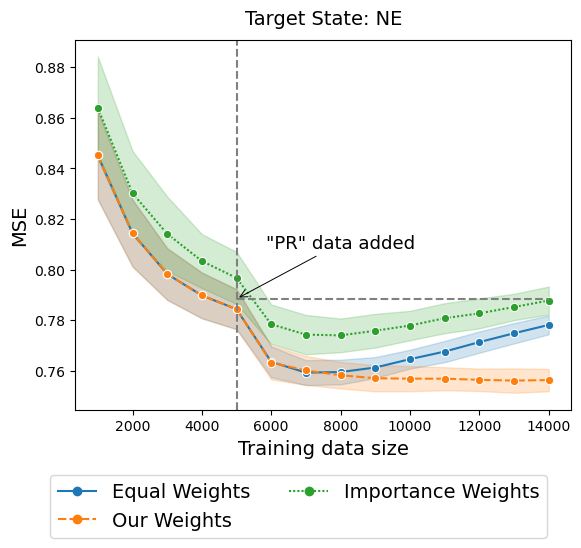

NV


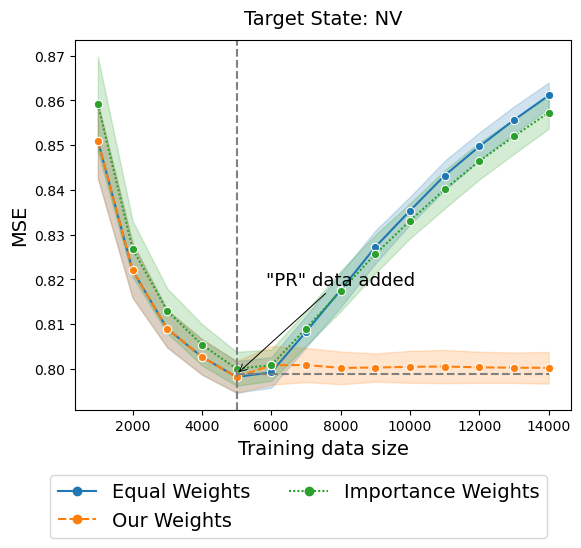

NH


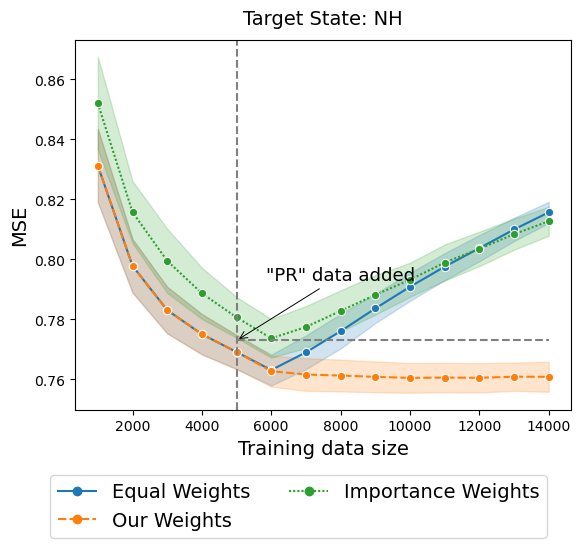

NJ


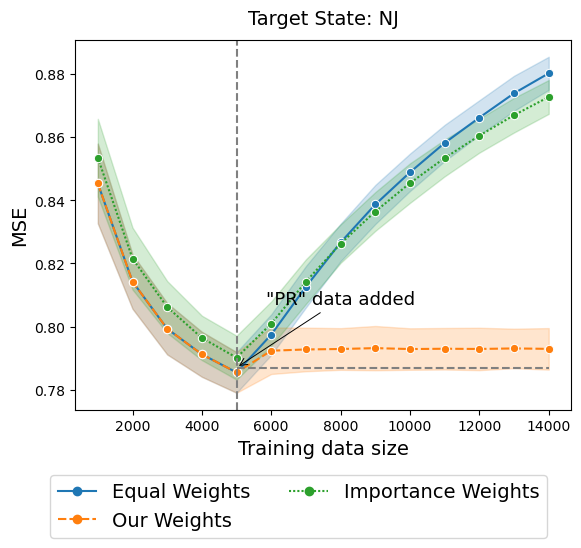

NM


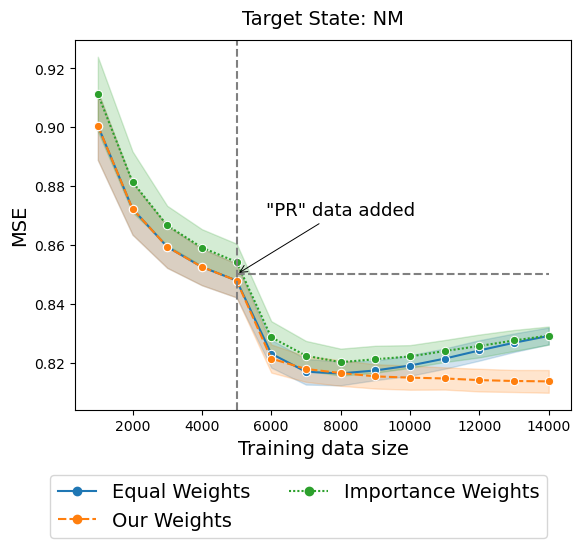

NY


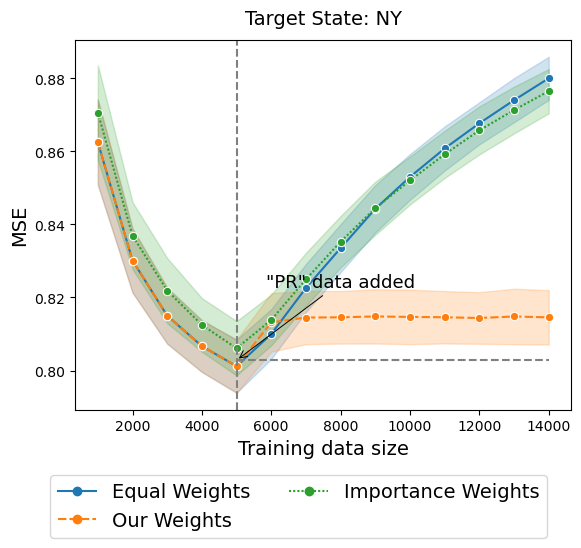

NC


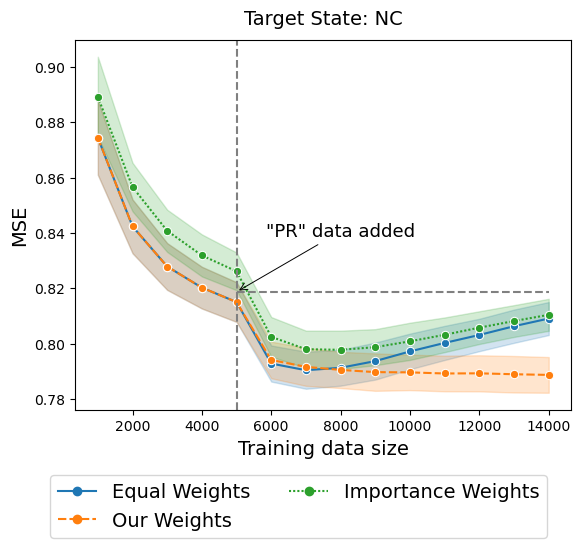

ND


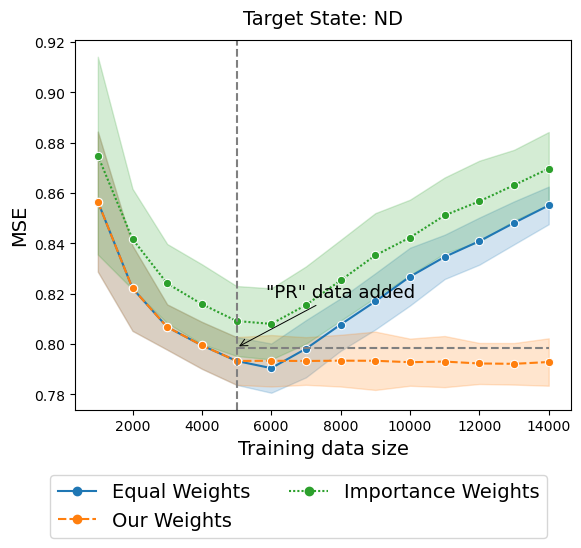

OH


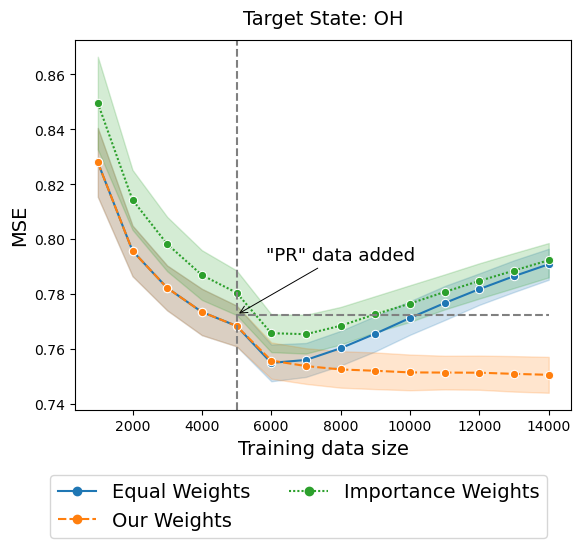

OK


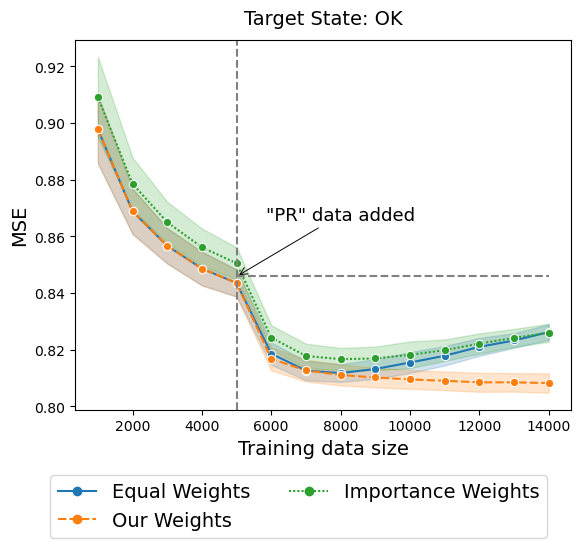

OR


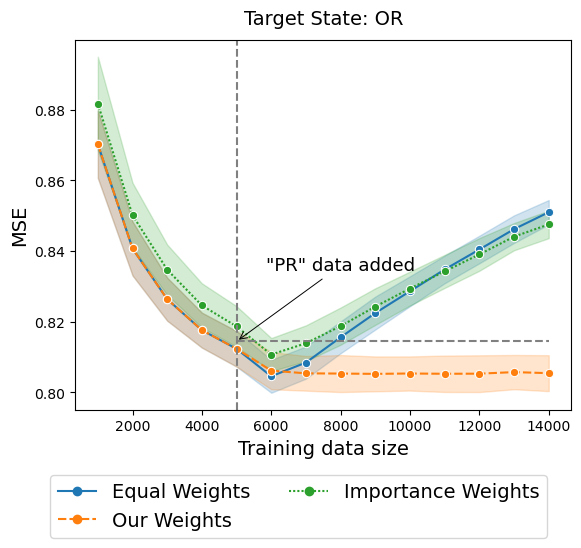

PA


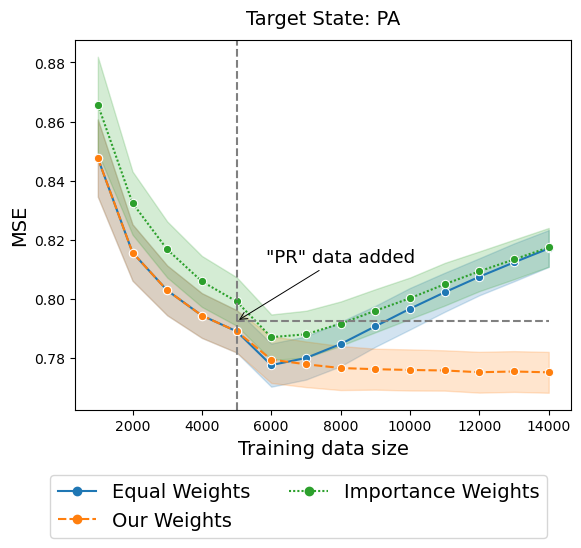

RI


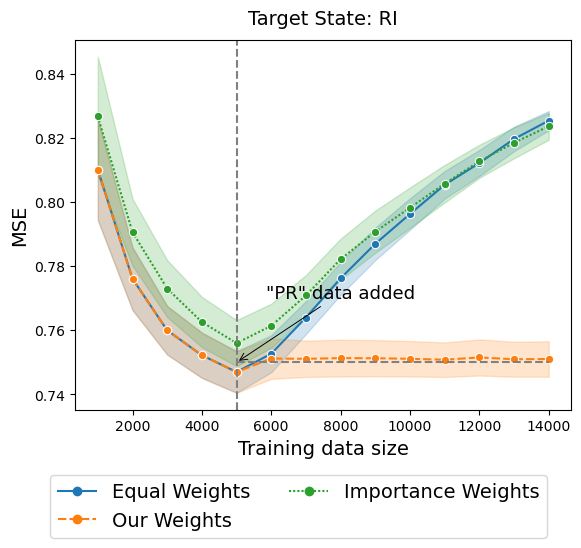

SC


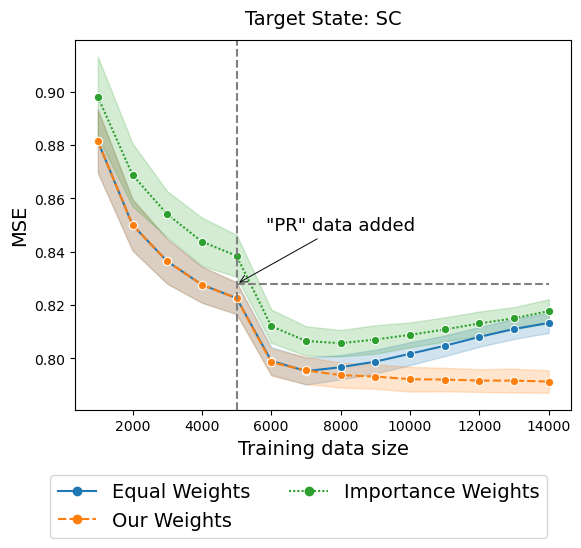

SD


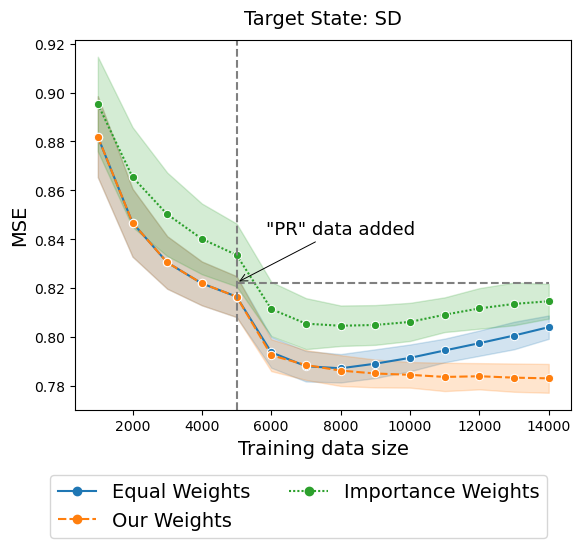

TN


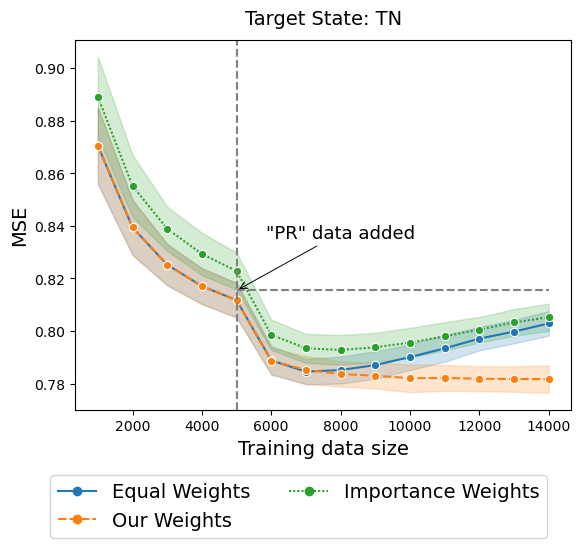

TX


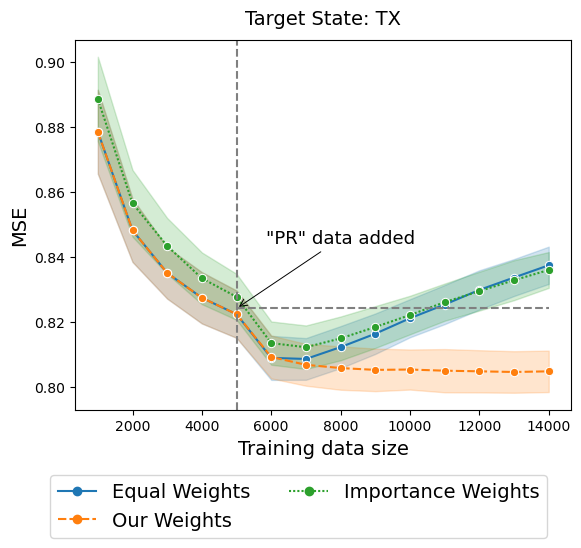

UT


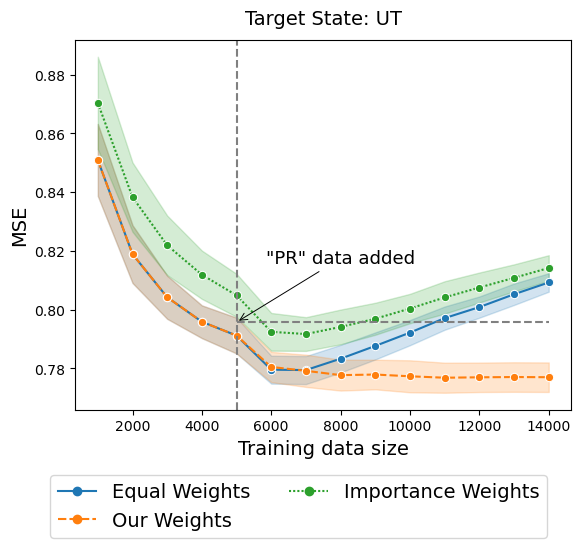

VT


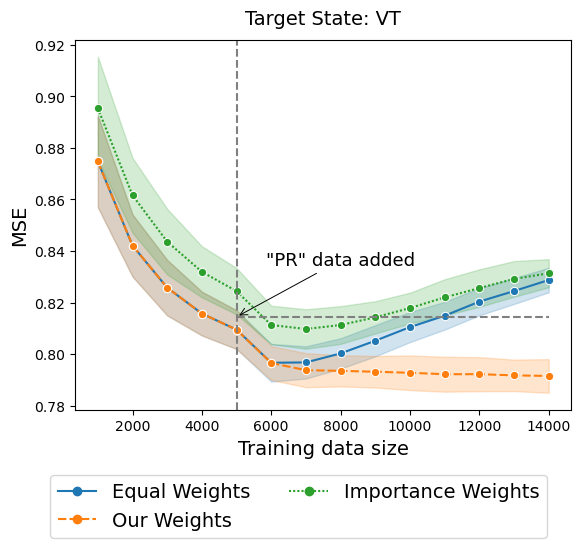

VA


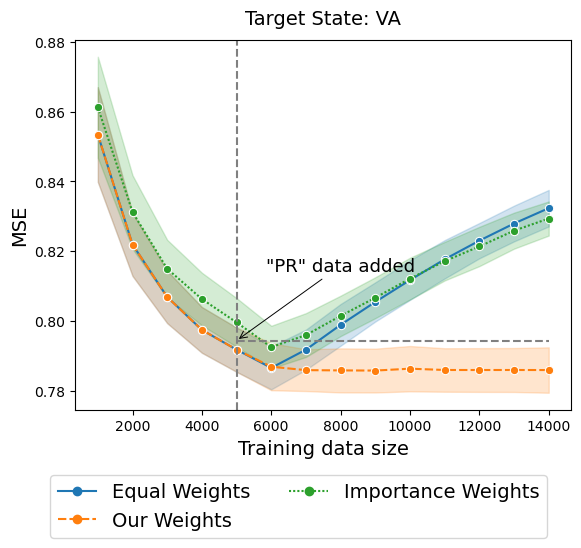

WA


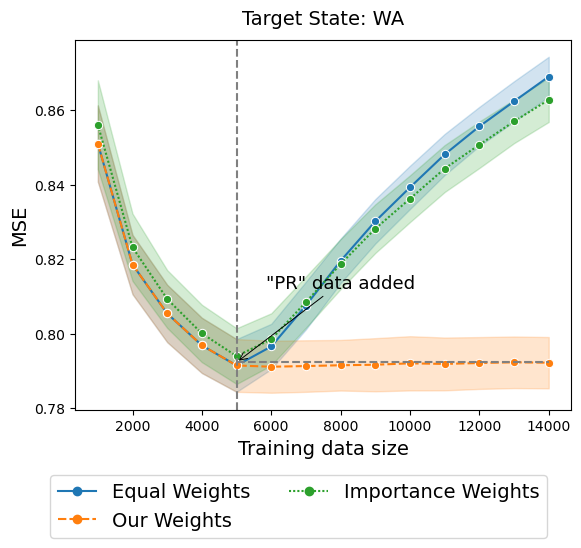

WV


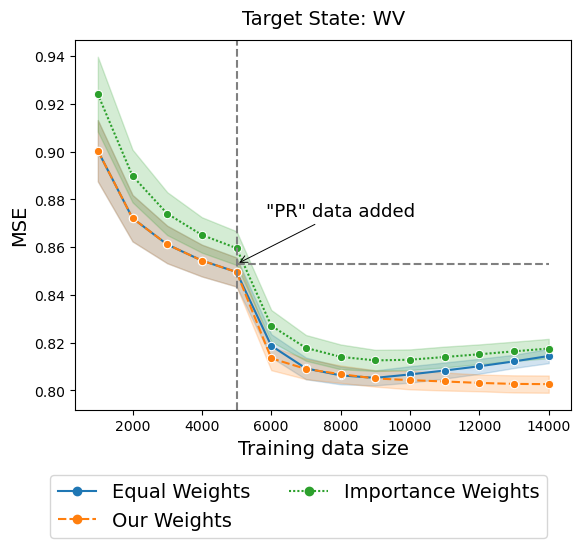

WI


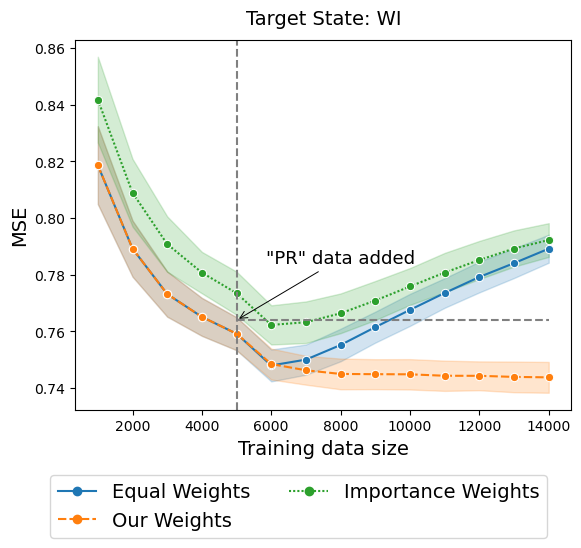

WY


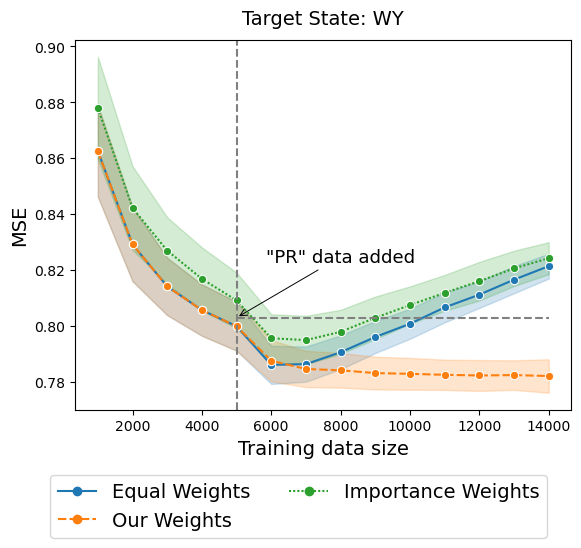

In [25]:
for state in STATES:
    if state != "CA" and state != "PR":
        print(state)
        ours, pooled, propsc = add_source_sim(state, nsims = 100)
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            df, g = create_plot(ours, pooled, propsc, target = state, n_t = 5000, n_p = 9000)